In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score,accuracy_score
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from matplotlib import pyplot as plt
from skopt.space import Integer, Categorical, Real
from skopt.utils import use_named_args
from skopt import gp_minimize

C:\Users\nagar\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
df=pd.read_csv('highUtilizationPredictionV2wco.csv')
race_dummies=pd.get_dummies(df['race'])
newdf=pd.concat([df,race_dummies],axis=1)
tr, ts = train_test_split(newdf, test_size=0.2)
# create list of input attributes
cls = list(newdf.columns)
cls.remove('race')
cls.remove('patient_id')
cls.remove('claimCount')
cls.remove('HighUtilizationY2')
print(cls)

['age', 'ELIX1', 'ELIX2', 'ELIX3', 'ELIX4', 'ELIX5', 'ELIX6', 'ELIX7', 'ELIX8', 'ELIX9', 'ELIX10', 'ELIX11', 'ELIX12', 'ELIX13', 'ELIX14', 'ELIX15', 'ELIX16', 'ELIX17', 'ELIX18', 'ELIX19', 'ELIX20', 'ELIX21', 'ELIX22', 'ELIX23', 'ELIX24', 'ELIX25', 'ELIX26', 'ELIX27', 'ELIX28', 'ELIX29', 'G-2', 'G-3', 'G-4', 'G-5', 'G-6', 'G-7', 'G-8', 'G-9', 'G-10', 'G-11', 'G-12', 'G-13', 'G-14', 'G-15', 'G-16', 'G-17', 'G-18', 'G-19', 'G-20', 'G-21', 'G-22', 'G-23', 'drugs_m0-1', 'drugs_m1-2', 'drugs_m2-3', 'drugs_m3-4', 'drugs_m4-5', 'drugs_m5-6', 'drugs_m6-7', 'drugs_m7-8', 'drugs_m8-9', 'drugs_m9-10', 'drugs_m10-11', 'drugs_m11-12', 'A', 'Am.N', 'B', 'H', 'O', 'U', 'W']


In [3]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(tr[cls], tr['HighUtilizationY2'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [4]:
probs_rf_tr = rf.predict_proba(tr[cls])[:,1]
probs_rf_ts = rf.predict_proba(ts[cls])[:,1]
roc_auc_score(ts['HighUtilizationY2'], probs_rf_ts)

0.7980931900738573

In [5]:
# Q1 removing all the claims which have claim count in the range of +/- 10 of 100.
ts1=ts[ts['claimCount']<90]
ts2=ts[ts['claimCount']>110]
new_ts=pd.concat([ts1,ts2])
probs_rf_newts = rf.predict_proba(new_ts[cls])[:,1]

Text(0.5,1,'Accuracy Vs Claim count (including claims around 100)')

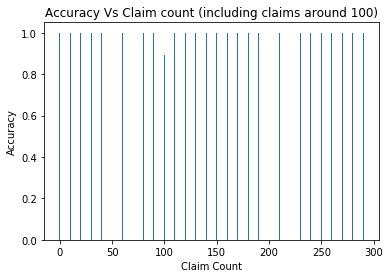

In [6]:
#accuracy
dist = []
for cnt in range(0,300,10):
    tt = ts[(ts['claimCount'] >= cnt) & (ts['claimCount'] < cnt + 10)]
    pred=cross_validate(rf, tt[cls], tt['HighUtilizationY2'], scoring=['accuracy'], cv=10)
    dist.append(np.mean(pred['test_accuracy']))
plt.bar(range(0,300,10), dist)
plt.xlabel('Claim Count')
plt.ylabel('Accuracy')
plt.title('Accuracy Vs Claim count (including claims around 100)')

Text(0.5,1,'Accuracy Vs Claim count(excluding claims in the range of +/-10 of 100 )')

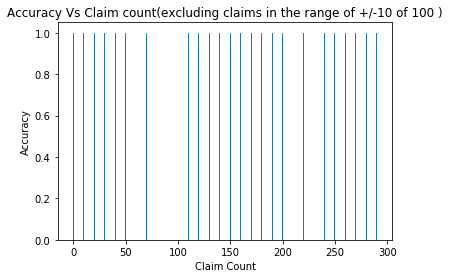

In [7]:
#accuracy
dist = []
for cnt in range(0,300,10):
    if cnt!=90 and cnt!=100:
        tt = new_ts[(new_ts['claimCount'] >= cnt) & (new_ts['claimCount'] < cnt + 10)]
        pred=cross_validate(rf, tt[cls], tt['HighUtilizationY2'], scoring=['accuracy'], cv=10)
        dist.append(np.mean(pred['test_accuracy']))
    else:
        dist.append(0)
    
plt.bar(range(0,300,10), dist)
plt.xlabel('Claim Count')
plt.ylabel('Accuracy')
plt.title('Accuracy Vs Claim count(excluding claims in the range of +/-10 of 100 )')

Text(0.5,1,'Probability Vs Claim count (includes all the claims)')

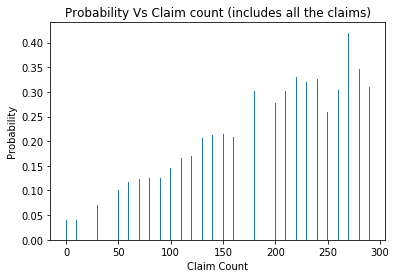

In [8]:
#Plot against the probability
dist = []
for cnt in range(0,300,10):
    tt = ts[(ts['claimCount'] >= cnt) & (ts['claimCount'] < cnt + 10)]
    dist.append( rf.predict_proba(tt[cls])[:,1].mean())
plt.bar(range(0,300,10), dist)
plt.xlabel('Claim Count')
plt.ylabel('Probability')
plt.title('Probability Vs Claim count (includes all the claims)')

Text(0.5,1,'Probability Vs Claim count(excludes claims +/- 10 of 100)')

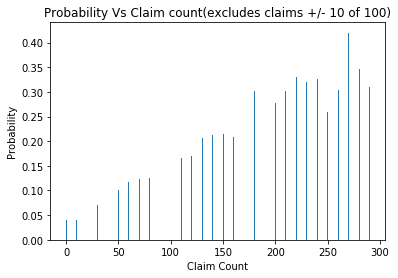

In [9]:
#Plot against the probability
dist = []
for cnt in range(0,300,10):
    if cnt!=90 and cnt!=100:
        tt = new_ts[(new_ts['claimCount'] >= cnt) & (new_ts['claimCount'] < cnt + 10)]
        pred=rf.predict_proba(tt[cls])[:,1]
        dist.append( pred.mean())
    else:
        dist.append(0)
    
plt.bar(range(0,300,10), dist)
plt.xlabel('Claim Count')
plt.ylabel('Probability')
plt.title('Probability Vs Claim count(excludes claims +/- 10 of 100)')


Global Sensitivity Analysis

In [10]:
# Function for global sensitivity analysis

def global_sensitivity(var,x,ts,tr,rf):
    dist = []
    dist1 = []
    for a in list(x):
        tt = pd.DataFrame(ts)
        tt[var] = a
        ttt = pd.DataFrame(tr)
        ttt[var] = a
        dist.append( rf.predict_proba(tt[cls])[:,1].mean())
        dist1.append( rf.predict_proba(ttt[cls])[:,1].mean())
    return dist,dist1

Text(0,0.5,'Probability')

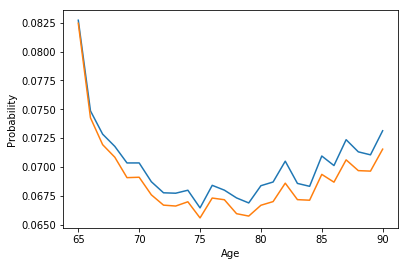

In [11]:
f_val=rf.feature_importances_
f_name=ts[cls].columns
features=pd.DataFrame()
features['f_name']=f_name
features['f_val']=f_val
features=features.sort_values('f_val',ascending=False)
features=features.reset_index()
x=ts[features['f_name'][0]].unique()
x.sort()
x
dist,dist1=global_sensitivity(features['f_name'][0],x,ts,tr,rf)
plt.plot(list(x),dist)
plt.plot(list(x),dist1) 
plt.xlabel('Age')
plt.ylabel('Probability')

In [12]:
# my code for data genration
import random
'''
The code requires var  which is the most important feature of the data and for every unique value of this feature 100 observation are genrated
Here, the most important variable is 'age', for every value of age we are generating 100 different combinations by identifying the unique values of the feature and randomly chosing a value.
The other requirement is the dataset and the list of features on which classifier is predicting.
'''
def data_generation(var,ts,cls):
    d=[]
    imp=ts[var].unique()
    imp.sort()
    col=list(ts[cls].columns)
    col.remove(var)
    for k in imp:
        for j in range(100):
            l=[]
            l.append(k)
            for i in col:
                x=list(ts[i].unique())
                if x!=len(ts):
                    l.append(random.choice(x))
                elif all(x.is_integer() for x in ts.i) ==True:
                    l.append(random.randint(min(ts[i]),max(ts[i])))
                elif all(x.is_integer() for x in ts.i) !=True:
                    l.append(random.uniform(min(ts[i]),max(ts[i])))
            d.append(l)
    return d

Text(0,0.5,'Probability')

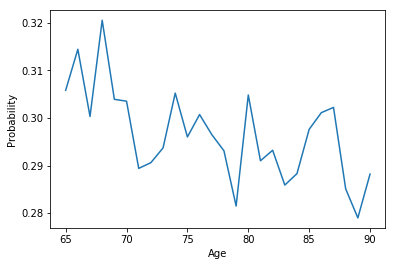

In [13]:
tr, ts = train_test_split(newdf, test_size=0.2)
var=features['f_name'][0]
d=data_generation(var,ts,cls)
Y = rf.predict_proba(d)[:,1]
X = np.array(d)[:,0]
ddd = pd.DataFrame(X, columns=[var])
ddd['prob'] = Y
YY = ddd.groupby(var).mean()
XX = range(min(ts[var]),max(ts[var])+1)
plt.plot(XX,YY)
plt.xlabel('Age')
plt.ylabel('Probability')
#(ddd.loc[ddd['age']==70]['prob']).mean()

local sensitivity analysis




In [14]:
# This is custom implementation of local sensitivity analysis function.
# cls is list of columns/features which are used for classification by the classifier
# test is test dataframe for analyzing binary or numeric columns 
# var is the name of the feature for which sensitivity analysis cannot be performed. 
# this feature is removed from list of columns while generating the new dataset but used later for predicting probabilities
# The list of columns should contain all the columns required for predicting and var should contain the features whhich need to be removed while genrating new dataset.
#test_case should be in data frame format and its probability should given in order to generate a difference.
def local_sensitivity(test,cls,var,test_case,case_prob,classifier):
    df=test[cls]
    col=list(df.columns)
    col.remove(var)
    d=pd.DataFrame()
    for i in col:
        x=list(df[i].unique())
        new_case=test_case.copy()
        new_case['feature_changed']=i
        if x!=len(df) and len(x)==2:
            if new_case[i]==x[0]:
                new_case['value_before']=x[0]
                new_case[i]=x[1]
                new_case['value_after_change']=new_case[i]
                d=d.append(new_case)
            else:
                new_case['value_before']=x[1]
                new_case[i]=x[0]
                new_case['value_after_change']=new_case[i]
                d=d.append(new_case)
        if x!=len(df) and len(x)>2:
            avg=df[i].mean()
            stdev=df[i].std()
            new_case['value_before']=new_case[i]
            if new_case[i]>avg:
                new_case[i]=new_case[i]-int(stdev)
                new_case['value_after_change']=new_case[i]
                d=d.append(new_case) 
            if new_case[i]<avg:
                new_case[i]=new_case[i]+int(stdev)
                new_case['value_after_change']=new_case[i]
                d=d.append(new_case)
    new_prob=classifier.predict_proba(d[cls])
    d1 = pd.DataFrame(d[['feature_changed','value_before','value_after_change']])
    d1['prob'] = new_prob[:,1]
    d1['change'] = new_prob[:,1] - case_prob
    return d1

In [15]:
# for case with high probability
prob=rf.predict_proba(ts[cls])[:,1]
cases=np.where(prob > 0.8)
print(cases)

(array([  357,   408,   420,   855,   861,   898,  1057,  1374,  1399,
        1610,  1851,  1894,  2554,  2569,  2672,  2748,  2831,  2929,
        3184,  3334,  3426,  3607,  3683,  3694,  3708,  3792,  4069,
        4291,  4321,  4509,  4520,  4842,  5014,  5031,  5071,  5089,
        5166,  5240,  5334,  5347,  5478,  5524,  5551,  5631,  5742,
        5802,  5868,  5893,  6203,  6550,  6625,  6736,  6908,  6922,
        7239,  7601,  7610,  7698,  8153,  8239,  8576,  8610,  8656,
        8739,  9103,  9247,  9259,  9283,  9717, 10007, 10227, 10356,
       10366, 10592, 10638, 10663, 10722, 10755, 10803, 10849, 11173,
       11251, 11306, 11357, 11507, 11627, 11657, 11886, 11925, 12068,
       12319, 12426, 12469, 12583, 12599, 12700, 13184, 13186, 13205,
       13357, 13469, 13627, 13856, 14092, 14249, 14462, 14466, 14506,
       14563, 14574, 14731, 14824, 15336, 15486, 15546, 15592, 15732,
       15743, 16035, 16115, 16642, 16725, 16766, 16774, 16838, 16871,
       16876, 17001

In [16]:
case_prob=prob[18434]
test_case = ts.iloc[18434]
var='age'
test=ts
dat=local_sensitivity(test,cls,var,test_case,case_prob,rf)

In [17]:
# features which decrease the probability 
dat[dat['change']<0.00].sort_values('change')[:10] 

,feature_changed,value_before,value_after_change,prob,change
21689,ELIX6,1.0,0.0,0.21,-0.64
21689,ELIX14,1.0,0.0,0.29,-0.56
21689,G-22,1.0,0.0,0.35,-0.50
21689,G-12,1.0,0.0,0.48,-0.37
21689,ELIX22,0.0,1.0,0.59,-0.26
21689,G-7,1.0,0.0,0.62,-0.23
21689,G-21,1.0,0.0,0.64,-0.21
21689,ELIX13,0.0,1.0,0.64,-0.21
21689,ELIX21,0.0,1.0,0.65,-0.20
21689,ELIX18,1.0,0.0,0.66,-0.19


In [18]:
# features which increase the probability
dat[dat['change']>0.00].sort_values('change',ascending=False)[:10]  

,feature_changed,value_before,value_after_change,prob,change
21689,ELIX2,0.0,1.0,0.86,0.01
21689,G-20,0.0,1.0,0.86,0.01


In [19]:
# for test case with low probability
prob=rf.predict_proba(ts[cls])[:,1]
cases=np.where(prob < 0.2)
print(cases)


(array([    1,     2,     3, ..., 22602, 22603, 22604], dtype=int64),)


In [27]:
case_prob=prob[22604]
test_case = ts.iloc[22604]
var='age'
test=ts
dat=local_sensitivity(test,cls,var,test_case,case_prob,rf)


In [28]:
 # features which decrease the probability 
dat[dat['change']<0.00].sort_values('change')[:10]  

,feature_changed,value_before,value_after_change,prob,change
45362,G-2,1.0,0.0,0.00,-0.04
45362,ELIX13,1.0,0.0,0.01,-0.03
45362,ELIX24,0.0,1.0,0.01,-0.03
45362,G-12,1.0,0.0,0.01,-0.03
45362,G-17,1.0,0.0,0.01,-0.03
45362,ELIX4,0.0,1.0,0.02,-0.02
45362,ELIX27,1.0,0.0,0.02,-0.02
45362,G-22,1.0,0.0,0.02,-0.02
45362,ELIX18,0.0,1.0,0.03,-0.01
45362,G-5,0.0,1.0,0.03,-0.01


In [29]:
# features which increase the probability
dat[dat['change']>0.00].sort_values('change',ascending=False)[:10]  

,feature_changed,value_before,value_after_change,prob,change
45362,ELIX10,0.0,1.0,0.37,0.33
45362,ELIX22,0.0,1.0,0.29,0.25
45362,ELIX21,0.0,1.0,0.25,0.21
45362,ELIX14,0.0,1.0,0.20,0.16
45362,ELIX1,0.0,1.0,0.19,0.15
45362,G-7,0.0,1.0,0.17,0.13
45362,ELIX29,0.0,1.0,0.14,0.10
45362,ELIX9,0.0,1.0,0.12,0.08
45362,ELIX3,0.0,1.0,0.11,0.07
45362,ELIX6,0.0,1.0,0.10,0.06
